# Lab 3: CNNs and Deep Learning

## TBMI26/732A55 Neural Networks and Learning Systems

## 2D Convolution

For the further steps, we often need to visualize an image and we define a shortcut for that:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function scipy.signal.convolve2d()

**Task 1**: Use this function to generate a 2D kernel of size 33×33 by five times cascading 2D convolutions of h with itself, starting with h = [[1/4, 1/4], [/14, 1/4]]

(33, 33)


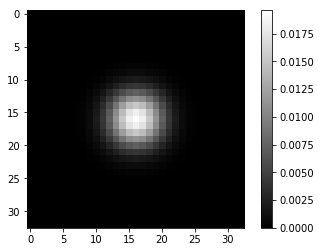

Image size: (33, 33)


In [2]:
import numpy as np
from scipy.signal import convolve2d

h = np.array([[1/4, 1/4],
              [1/4, 1/4]])
kernel = h

for i in range(5):
    kernel = convolve2d(kernel, kernel)

# The dtype is changed to make it work
# with the same dtype as tf.
kernel = kernel.astype(np.float32)
    
print(kernel.shape)
visualize(kernel)

**Task 2**: Now, load the image 'MR15^044.JPG' (a sample from ImageNet), convert it to gray-scale by summing its R-, G-, and B-values at each pixel, and normalize it to the interval [0;1]. Convolve it with h from the previous task with the options 'valid' and 'same'. Visualize all three images. What differences do you observe regarding the size and intensity of the output?


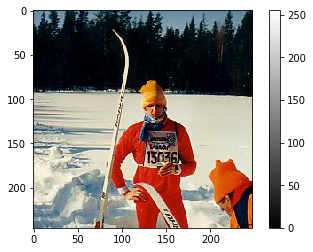

Image size: (246, 248, 3)


In [3]:
img = plt.imread("photo.JPG")
visualize(img)

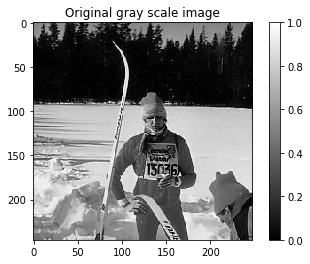

Image size: (246, 248)


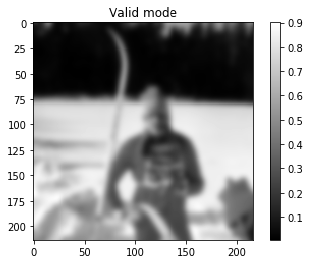

Image size: (214, 216)


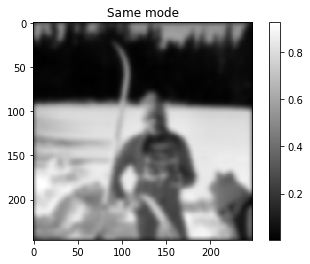

Image size: (246, 248)


In [4]:
# Summing up all the colours on each pixel.
img_gray = img.sum(axis=2)

# Rescaling.
img_gray = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min())

# The dtype is changed to make it work
# with the same dtype as tf.
img_gray = img_gray.astype(np.float32)

# Convolving the image.
cimg_valid = convolve2d(img_gray, kernel, mode="valid")
cimg_same = convolve2d(img_gray, kernel, mode="same")

# Plotting the images.
plt.title("Original gray scale image")
visualize(img_gray)

plt.title("Valid mode")
visualize(cimg_valid)

plt.title("Same mode")
visualize(cimg_same)

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.

**Task 3**: Visualize the original gray-scale image and the output image from the previous task (with option 'same') with only keping every fifth row and column (stride 5). What do you observe, in particular at the ski?

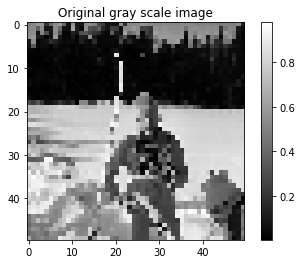

Image size: (50, 50)


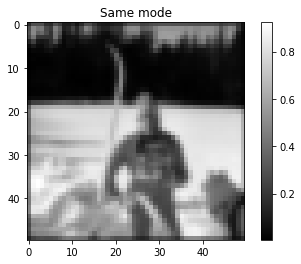

Image size: (50, 50)


In [5]:
# Plotting the images with stride 5.
plt.title("Original gray scale image")
visualize(img_gray[::5, ::5])

plt.title("Same mode")
visualize(cimg_same[::5, ::5])

# Convolutions in Tensorflow

We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform eager execution. This is initialized as follows:

In [6]:
import tensorflow as tf
import tensorflow.keras as K

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')



TensorFlow version 1.12.0
Eager execution activated!


/home/h4pz/anaconda3/envs/ml36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


TensorFlow allows to map from and to numpy. Also, operations are automatically casted. In order to get used to TensorFlow and the casting, we repeat the convolution 1.a) from class 5 (see Lisam). As you have learned in the lecture, any convolution with kernel h can also be performed as matrix multiplication by the Toeplitz matrix H.

**Task 4**: Use scipy.linalg.toeplitz to generate the matrix H for the kernel h=[1, 2, -2] and boundary condition 'same' and f = [1 , -1, -2, 0, -1, 1, 2, -1]  in TensorFlow (tf.constant()). Multiply H and f and display the result. Verify that the result is the same as in 1.a). What are the respective classes of H, f, and the result?

In [7]:
from scipy.linalg import toeplitz

h = np.array([1, 2, -2])
col = np.concatenate((h[1:], np.zeros(8)))
row = np.concatenate((h[1::-1], np.zeros(8)))
H = toeplitz(col, row)
print(H)

[[ 2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -2.  2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2.  2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -2.  2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -2.  2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -2.  2.]]


In [8]:
f = tf.constant([0, 1, -1, -2, 0, -1, 1, 2, -1, 0], shape=(10, 1))
print(f)

tf.Tensor(
[[ 0]
 [ 1]
 [-1]
 [-2]
 [ 0]
 [-1]
 [ 1]
 [ 2]
 [-1]
 [ 0]], shape=(10, 1), dtype=int32)


In [9]:
res = H @ f
print(res)

tf.Tensor(
[[ 1]
 [ 1]
 [-6]
 [-2]
 [ 3]
 [-1]
 [ 6]
 [ 1]
 [-6]
 [ 2]], shape=(10, 1), dtype=int32)


In [10]:
print(type(H))
print(type(f))
print(type(res))

<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


Keras layers can be applied in eager mode using the tf.keras.layers package. NOTE: tf.keras.layers and NOT keras.layers.

**Task 5**: Perform the convolution from the previous task using a convolution layer Conv1D and a (trivial) Sequential model from tf.keras.
Hints: RTFM of tf.keras.Sequential - weights can be set for the model (list) or the layer (by traversing the layers list). Apply use_bias=False to avoid random DC-shifts.

In [11]:
# Setting up the model.
model = K.Sequential([K.layers.Conv1D(filters=1,
                                      kernel_size=3,
                                      strides=1,
                                      use_bias=False,
                                      input_shape=(10, 1),
                                      padding="same")])

# Setting the weights.
model.set_weights([h[::-1].reshape((3, 1, 1))])

# Transforming the input to match the shape
# of the model input.
ff = tf.constant([0, 1, -1, -2, 0, -1, 1, 2, -1, 0],
                 shape=(1, 10, 1),
                 dtype=tf.float32)

# Doing the convolution.
model(ff)

<tf.Tensor: id=34, shape=(1, 10, 1), dtype=float32, numpy=
array([[[ 1.],
        [ 1.],
        [-6.],
        [-2.],
        [ 3.],
        [-1.],
        [ 6.],
        [ 1.],
        [-6.],
        [ 2.]]], dtype=float32)>

**Task 6**: Apply the cascaded 33×33
filter from task 1 to the image from task 2 using a Conv2D layer. Compare the result visually and by subtracting the fitting result from task 2.

**Answer:**
The kernel is applied with both paddings (same and valid) and compared to both images below. From the output below we can see that both convolutions yield the same result. The difference between values is due to numerical error since the first image is calculated over the cpu and the second one over the gpu.

In [12]:
################
# SAME PADDING #
################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=1,
                                      use_bias=False,
                                      padding="same",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([kernel.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_same = model(timg_gray).numpy().squeeze()

# Saving the results for task 9.
X = timg_gray
y = res_same

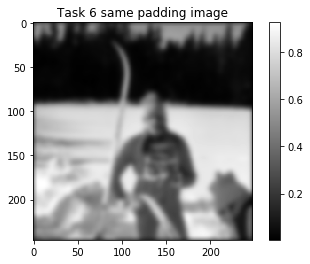

Image size: (246, 248)


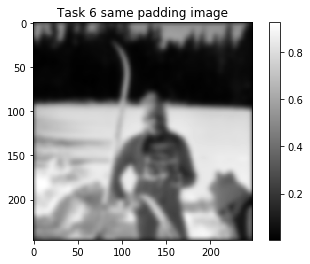

Image size: (246, 248)
Sum of the difference between all pixels of the images: 0.00010239239782094955


In [13]:
# Visualizing the results and comparing by substraction.
plt.title("Task 6 same padding image")
visualize(res_same)

plt.title("Task 6 same padding image")
visualize(cimg_same)

sum_diff_same = np.abs(np.sum(res_same - cimg_same))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")

In [14]:
#################
# VALID PADDING #
#################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=1,
                                      use_bias=False,
                                      padding="valid",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([kernel.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_valid = model(timg_gray).numpy().squeeze()

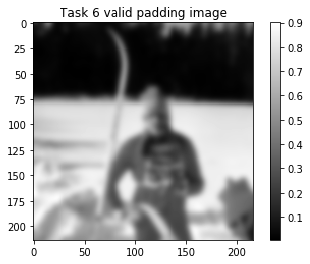

Image size: (214, 216)


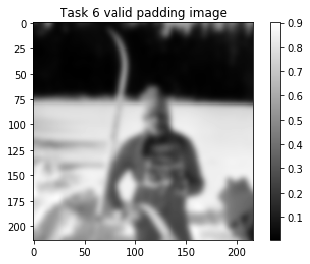

Image size: (214, 216)
Sum of the difference between all pixels of the images: 0.009943358600139618


In [15]:
# Visualizing the results and comparing by substraction.
plt.title("Task 6 valid padding image")
visualize(res_valid)

plt.title("Task 6 valid padding image")
visualize(cimg_valid)

sum_diff_valid = np.abs(np.sum(res_valid - cimg_valid))
print(f"Sum of the difference between all pixels of the images: {sum_diff_valid}")

**Task 7**: Repeat the previous task with stride 5 and compare the result visually and by subtracting the fitting result from task 3. Repeat the task, but with a 1×1

filter (coefficient 1) and stride 5. Compare again the result visually and by subtracting the fitting result from task 3.
Hint: You might need to adjust the offset for the subsampling.


In [16]:
################
# SAME PADDING #
################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=5,
                                      use_bias=False,
                                      padding="same",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([kernel.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_same = model(timg_gray).numpy().squeeze()

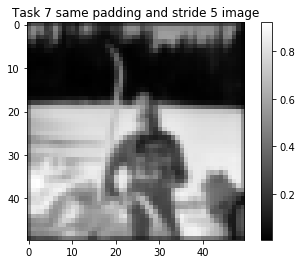

Image size: (50, 50)


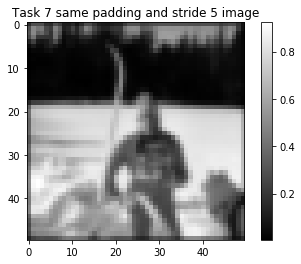

Image size: (50, 50)
Sum of the difference between all pixels of the images: 0.44582441449165344


In [17]:
# Visualizing the results and comparing by substraction.
plt.title("Task 7 same padding and stride 5 image")
visualize(res_same)

plt.title("Task 7 same padding and stride 5 image")
visualize(cimg_same[::5, ::5])

sum_diff_same = np.abs(np.sum(res_same - cimg_same[::5, ::5]))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")

In [18]:
#################
# VALID PADDING #
#################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=5,
                                      use_bias=False,
                                      padding="valid",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([kernel.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_valid = model(timg_gray).numpy().squeeze()

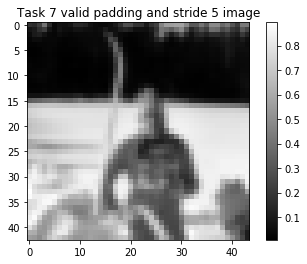

Image size: (43, 44)


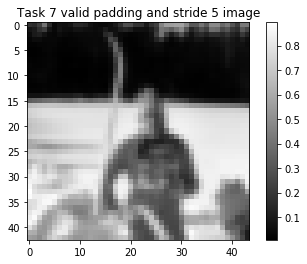

Image size: (43, 44)
Sum of the difference between all pixels of the images: 2.0271632820367813e-05


In [19]:
# Visualizing the results and comparing by substraction.
plt.title("Task 7 valid padding and stride 5 image")
visualize(res_valid)

plt.title("Task 7 valid padding and stride 5 image")
visualize(cimg_valid[::5, ::5])

sum_diff_same = np.abs(np.sum(res_valid - cimg_valid[::5, ::5]))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")

In [20]:
##############################################
# Same excersice for the kernel of shape 1x1 #
##############################################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=(1,1),
                                      strides=5,
                                      use_bias=False,
                                      padding="same",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([np.array([1]).reshape((1, 1, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_same = model(timg_gray).numpy().squeeze()

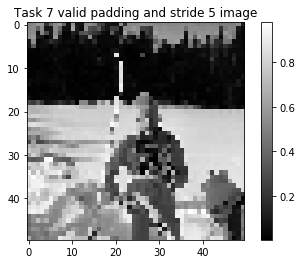

Image size: (50, 50)


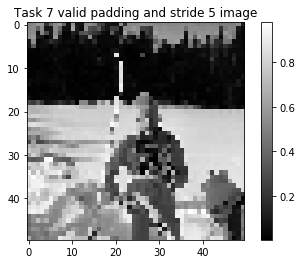

Image size: (50, 50)
Sum of the difference between all pixels of the images: 0.0


In [21]:
# Visualizing the results and comparing by substraction.
plt.title("Task 7 valid padding and stride 5 image")
visualize(img_gray[::5, ::5])

plt.title("Task 7 valid padding and stride 5 image")
visualize(res_same)

sum_diff_same = np.abs(np.sum(img_gray[::5, ::5] - res_same))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")

We now define a new filter that is, unlike h, anti-symmetric:

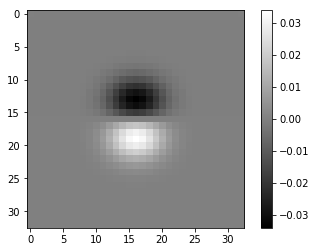

Image size: (33, 33)


In [22]:
fsz = 33
hfsz = 17
g = kernel * (np.expand_dims(np.arange(-hfsz+1,hfsz),1)@np.ones((1,fsz)))
visualize(g)

**Task 8**: repeat tasks 6 & 7 with g instead of h. What difference do you observe and why?

Repeating task 6

In [23]:
################
# SAME PADDING #
################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=1,
                                      use_bias=False,
                                      padding="same",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([g.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_same = model(timg_gray).numpy().squeeze()

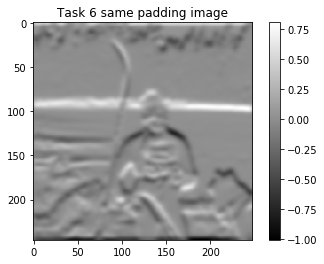

Image size: (246, 248)


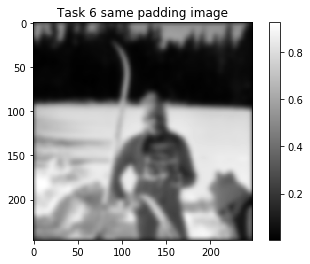

Image size: (246, 248)
Sum of the difference between all pixels of the images: 25409.66015625


In [24]:
# Visualizing the results and comparing by substraction.
plt.title("Task 6 same padding image")
visualize(res_same)

plt.title("Task 6 same padding image")
visualize(cimg_same)

sum_diff_same = np.abs(np.sum(res_same - cimg_same))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")

In [25]:
#################
# VALID PADDING #
#################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=1,
                                      use_bias=False,
                                      padding="valid",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([g.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_valid = model(timg_gray).numpy().squeeze()

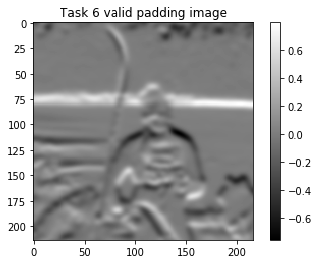

Image size: (214, 216)


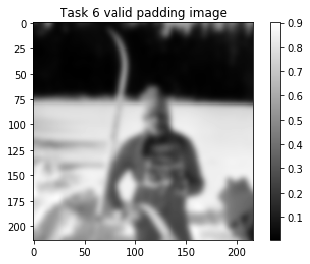

Image size: (214, 216)
Sum of the difference between all pixels of the images: 18940.4375


In [26]:
# Visualizing the results and comparing by substraction.
plt.title("Task 6 valid padding image")
visualize(res_valid)

plt.title("Task 6 valid padding image")
visualize(cimg_valid)

sum_diff_valid = np.abs(np.sum(res_valid - cimg_valid))
print(f"Sum of the difference between all pixels of the images: {sum_diff_valid}")

Repeating task 7

In [27]:
################
# SAME PADDING #
################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=5,
                                      use_bias=False,
                                      padding="same",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([g.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_same = model(timg_gray).numpy().squeeze()

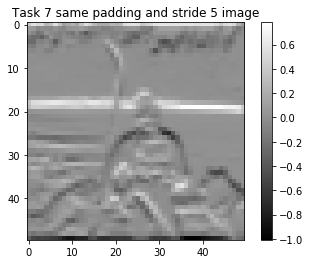

Image size: (50, 50)


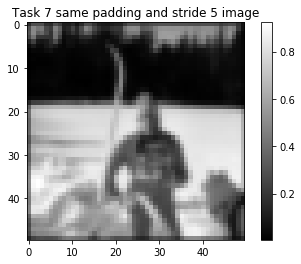

Image size: (50, 50)
Sum of the difference between all pixels of the images: 1032.64892578125


In [28]:
# Visualizing the results and comparing by substraction.
plt.title("Task 7 same padding and stride 5 image")
visualize(res_same)

plt.title("Task 7 same padding and stride 5 image")
visualize(cimg_same[::5, ::5])

sum_diff_same = np.abs(np.sum(res_same - cimg_same[::5, ::5]))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")

In [29]:
#################
# VALID PADDING #
#################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=5,
                                      use_bias=False,
                                      padding="valid",
                                      input_shape=(246, 248, 1))])

# Setting the weights.
model.set_weights([g.reshape((33, 33, 1 ,1))])

# Transforming the input so it matches with
# what is expected.
timg_gray = tf.constant(img_gray,
                        dtype=tf.float32,
                        shape=(1,) + img_gray.shape + (1,))

# Doing the convolution.
res_valid = model(timg_gray).numpy().squeeze()

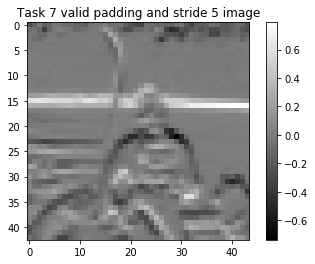

Image size: (43, 44)


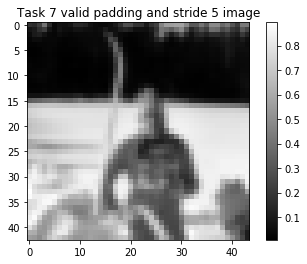

Image size: (43, 44)
Sum of the difference between all pixels of the images: 775.3350830078125


In [30]:
# Visualizing the results and comparing by substraction.
plt.title("Task 7 valid padding and stride 5 image")
visualize(res_valid)

plt.title("Task 7 valid padding and stride 5 image")
visualize(cimg_valid[::5, ::5])

sum_diff_same = np.abs(np.sum(res_valid - cimg_valid[::5, ::5]))
print(f"Sum of the difference between all pixels of the images: {sum_diff_same}")


## Training layers

We now take the input and output from task 6 as training data (input and output) for supervised learning of a convolution layer.

**Task 9**: Although we only have a single input and output image, we can expect the training to work, although this usually requires multiple samples. Why? Define two tensors batch and label that contain the data from task 6.


In [31]:
# These are going to be our inputs and outputs.
print(X.get_shape())  # Tensor / Input.
print(y.shape)  # Numpy array / label.

(1, 246, 248, 1)
(246, 248)


In [32]:
# We need to reshape y in order to fit the dimensions we want.
y = y.reshape((1,) + y.shape + (1,))
print(y.shape)

(1, 246, 248, 1)


**Task 10**: We want to apply the L1-loss. Define a suitable function loss(model, x, y) that can be used during training.

In [33]:
def loss(model, X, y):
    """Function that returns the L1 cost for a model.
    
    Parameters
    ----------
    model: keras Sequential model
        Keras model that's going to have as input
        X and output y_hat.
    X: np.array or tensor
        Multidimensional array that contains the input of
        the model.
    y: np.array or tensor
        Multidimensional array that contains the labels for
        the input X.
        
    Returns
    -------
    Tensor that is going to hold the L1 loss for the desired
    model, input X and label y.
    """
    y_hat = model(X)
    return tf.reduce_mean(tf.abs(y_hat - y))

Training a layers requires computing the gradient. For TF in eager mode, we use GradientTape() for this purpose.

**Task 11**: Train the model from task 6 (but without assigning the weights) using the data from task 9, the loss from task 10, and GradientDescentOptimizer(). During training, print the loss every 100 steps and visualize the learned kernel after training.
Hint: add a kernel_constraint to be non-negative.

In [34]:
%%time

################
# SAME PADDING #
################

# Setting up the model.
model = K.Sequential([K.layers.Conv2D(filters=1,
                                      kernel_size=kernel.shape,
                                      strides=1,
                                      use_bias=False,
                                      padding="same",
                                      input_shape=(246, 248, 1),
                                      kernel_constraint=K.constraints.NonNeg())])

# Training the model.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)

train_steps = 5000

for i in range(train_steps):
    with tf.GradientTape() as tape:
        loss_value = loss(model, X, y)
        dw = tape.gradient(loss_value, model.variables)  
        optimizer.apply_gradients(zip(dw, model.variables))
        
        if (i + 1) % 100 == 0:
            print(f"Iteration: {i + 1 : 5d} | Loss: {loss_value : .5f}")

Iteration:   100 | Loss:  4.40416
Iteration:   200 | Loss:  3.63294
Iteration:   300 | Loss:  2.91933
Iteration:   400 | Loss:  2.27434
Iteration:   500 | Loss:  1.70388
Iteration:   600 | Loss:  1.20337
Iteration:   700 | Loss:  0.78000
Iteration:   800 | Loss:  0.42524
Iteration:   900 | Loss:  0.15674
Iteration:  1000 | Loss:  0.08666
Iteration:  1100 | Loss:  0.08017
Iteration:  1200 | Loss:  0.07432
Iteration:  1300 | Loss:  0.06871
Iteration:  1400 | Loss:  0.06335
Iteration:  1500 | Loss:  0.05819
Iteration:  1600 | Loss:  0.05324
Iteration:  1700 | Loss:  0.04850
Iteration:  1800 | Loss:  0.04400
Iteration:  1900 | Loss:  0.03977
Iteration:  2000 | Loss:  0.03585
Iteration:  2100 | Loss:  0.03229
Iteration:  2200 | Loss:  0.02892
Iteration:  2300 | Loss:  0.02572
Iteration:  2400 | Loss:  0.02272
Iteration:  2500 | Loss:  0.02002
Iteration:  2600 | Loss:  0.01756
Iteration:  2700 | Loss:  0.01531
Iteration:  2800 | Loss:  0.01323
Iteration:  2900 | Loss:  0.01140
Iteration:  30

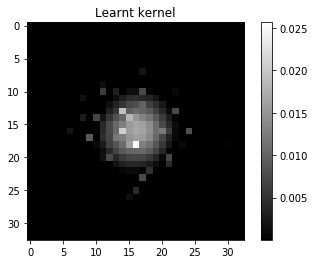

Image size: (33, 33)


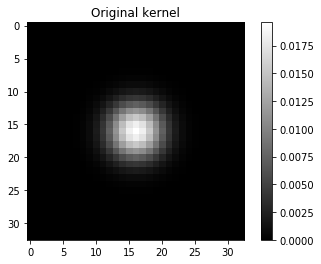

Image size: (33, 33)
Sum of the difference between all pixels of the kernels: 0.02342996932566166


In [35]:
# Getting the kernel and transforming it for plotting.
learnt_kernel = model.get_weights()[0]
learnt_kernel = learnt_kernel.squeeze()

# Visualizing the original and learnt kernel.
plt.title("Learnt kernel")
visualize(learnt_kernel)

plt.title("Original kernel")
visualize(kernel)

sum_diff_same = np.abs(np.sum(kernel - learnt_kernel))
print(f"Sum of the difference between all pixels of the kernels: {sum_diff_same}")

## Training a whole network

So far, we have been training a single layer and we have been following the progress with the help of the Eager mode. If we want to train a whole network, it is much better to leave the Eager mode and to compile the graph. For this, we need to kill the notebook kernel ("Kernel" -> "Restart"). After that, we continue below in the classical TensorFlow mode.

**Task 12**: We will train on CIFAR10, which is contained in keras.datasets. Download the dataset, show a sample for each class, convert the labels to one-hot coding, and normalize the images.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as K

/home/h4pz/anaconda3/envs/ml36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


In [2]:
tf.executing_eagerly() 

False

In [3]:
# Loading the data.
train, test = K.datasets.cifar10.load_data()

X_train, y_train = train
X_test, y_test = test

In [4]:
print("Shape of X_train and y_train")
print(X_train.shape)
print(y_train.shape)
print("\nShape of X_test and y_test")
print(X_test.shape)
print(y_test.shape)

Shape of X_train and y_train
(50000, 32, 32, 3)
(50000, 1)

Shape of X_test and y_test
(10000, 32, 32, 3)
(10000, 1)


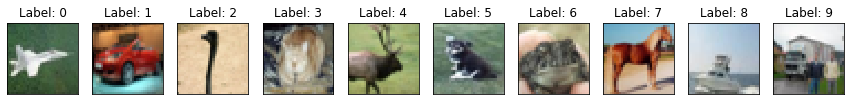

In [5]:
# Creating the figure and axes.
fig, axs = plt.subplots(1, 10, figsize=(15, 10))

for c in range(10):
    # Getting the image.
    img = X_train[(y_train == c)[:, 0], ...][4]
    
    # Plotting it on the corresponding axes.
    axs[c].imshow(img)
    
    # Removing the axis for x and y.
    axs[c].get_xaxis().set_visible(False)
    axs[c].get_yaxis().set_visible(False)
    
    # Setting the title for each label.
    axs[c].set_title(f"Label: {c}")

In [6]:
# Converting the labels to one hot encoding.
yohe_train = np.squeeze(np.eye(10)[y_train])
yohe_test = np.squeeze(np.eye(10)[y_test])

# Normalizing the images.
Xnorm_train = X_train / 255.0
Xnorm_test = X_test / 255.0

**Task 13**: Build the depicted LeNet5-inspired model using Keras standard components.

In [7]:
# Hyperparameters of the network.
filters = [32, 64, 128]
dropout_rates = [0.2, 0.3, 0.4]

# Defining the input.
inputs = K.layers.Input(shape=Xnorm_train[0, ...].shape)
x = inputs

# Creating the intermediate layers.
for i in range(3):
    x = K.layers.Conv2D(filters[i], (3, 3), padding="same")(x)
    x = K.layers.Activation("elu")(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Conv2D(filters[i], (3, 3), padding="same")(x)
    x = K.layers.Activation("elu")(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = K.layers.Dropout(dropout_rates[i])(x)

# Flattening the output.
x = K.layers.Flatten()(x)

# Getting the predictions.
predictions = K.layers.Dense(10, activation="softmax")(x)

model = K.models.Model(inputs=inputs, outputs=predictions)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
__________

**Task 14**: Train the defined model for 50 epochs and a suitable batch size and display the result.

In [9]:
# Compiling the model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
%%time
model.fit(Xnorm_train, yohe_train,
          batch_size=50,
          epochs=50,
          validation_data=(Xnorm_test, yohe_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.6101 - acc: 0.4853 - val_loss: 1.0410 - val_acc: 0.6459
Epoch 2/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.0138 - acc: 0.6539 - val_loss: 0.8669 - val_acc: 0.7030
Epoch 3/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.8345 - acc: 0.7107 - val_loss: 0.7676 - val_acc: 0.7419
Epoch 4/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.7274 - acc: 0.7467 - val_loss: 0.7065 - val_acc: 0.7567
Epoch 5/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.6502 - acc: 0.7756 - val_loss: 0.6967 - val_acc: 0.7700
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.5857 - acc: 0.7970 - val_loss: 0.6328 - val_acc: 0.7863
Epoch 7/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.5395 - acc: 0.8119 - val_loss: 0.6232 - 

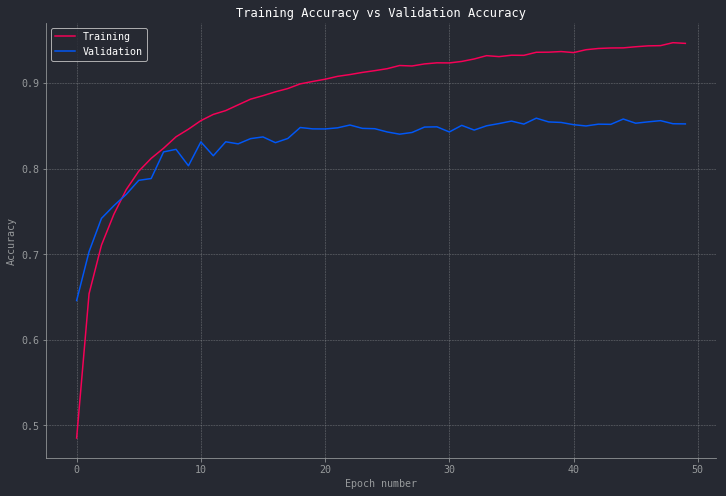

In [12]:
# Changing the style of the plot.
plt.style.use("new_bermuda")

# Creating the plot.
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(model.history.history['acc'])
ax.plot(model.history.history['val_acc'])
ax.set_xlabel("Epoch number")
ax.set_ylabel("Accuracy")
ax.set_title("Training Accuracy vs Validation Accuracy")
ax.legend(['Training','Validation'])